In [7]:
from wKit.vis import plotly_fig

In [1]:
from read_db_json import *

In [2]:
from sklearn.metrics import r2_score, mean_squared_error

In [8]:
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
# date = '2017-09-29'
date='2017-08-30'
date = '2017-10-01'

In [4]:
# ratings = large_joint_table(date=date)
joint_table = load_joint_table2(date=date)

with test (1476, 13)
without test users (1476, 13)


In [5]:
joint_table.shape

(2339, 32)

In [6]:
y_all = weighted_seg_score(joint_table)

y_all.shape

(442, 1)

In [7]:
# y_all.to_csv('ys/{0}/y_csl_all-{0}.csv'.format(date))

# EXP1 3 levels

In [40]:
y_all_3 = (y_all-1)/(5-1) * (3-1) + 1

In [41]:
y_all_3.to_csv('ys/{0}/y_csl_all_3level-{0}.csv'.format(date))

In [69]:
y_all_4 = (y_all-1)/(5-1) * (4-1) + 1

In [8]:
y_all_4.to_csv('ys/{0}/y_csl_all_4level-{0}.csv'.format(date))

In [71]:
%matplotlib inline

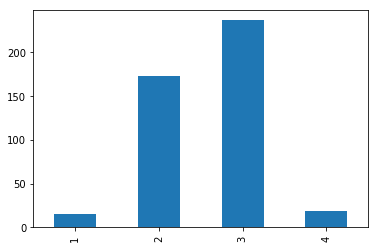

In [80]:
y_all_4.csl.round().value_counts().loc[[1,2,3,4]].plot(kind='bar')

# EXP1 weighted score by familiar or explvl

In [16]:
def lvl_fearless_1st(lvl):
    """ ignore user with no exp lvl"""
    if pd.isnull(lvl):
        return 0
    return {'fearless': 4, 'confident': 3, 'interested': 2, 'reluctant': 1}[lvl]

def lvl_reluctant_1st(lvl):
    """ ignore user with no exp lvl"""
    if pd.isnull(lvl):
        return 0
    return {'fearless': 1, 'confident': 2, 'interested': 3, 'reluctant': 4}[lvl]

def familiar_include_no_info(fam):
    if pd.isnull(fam):
        return 2
    return {'no': 1, 'yes':3}[fam]

def familiar_exclude_no_info(fam):
    if pd.isnull(fam):
        return 0
    return {'no': 1, 'yes':2}[fam]

In [17]:
def ext_lvl_fearless_1st(lvl):
    """ ignore user with no exp lvl"""
    if pd.isnull(lvl):
        return 0
    return {'fearless': 100, 'confident': 66, 'interested': 33, 'reluctant': 1}[lvl]

def ext_lvl_reluctant_1st(lvl):
    """ ignore user with no exp lvl"""
    if pd.isnull(lvl):
        return 0
    return {'fearless': 1, 'confident': 33, 'interested': 66, 'reluctant': 100}[lvl]

def ext_familiar_include_no_info(fam):
    if pd.isnull(fam):
        return 50
    return {'no': 1, 'yes':100}[fam]

def ext_familiar_exclude_no_info(fam):
    if pd.isnull(fam):
        return 0
    return {'no': 1, 'yes':100}[fam]

In [18]:
joint_table['lvl_fearless_1st'] = joint_table.experienceLevel.apply(lvl_fearless_1st)
joint_table['lvl_reluctant_1st'] = joint_table.experienceLevel.apply(lvl_reluctant_1st)
joint_table['fam_include_noinfo'] = joint_table.familiar.apply(familiar_include_no_info)
joint_table['fam_exclude_noinfo'] = joint_table.familiar.apply(familiar_exclude_no_info)

joint_table['ext_lvl_fearless_1st'] = joint_table.experienceLevel.apply(ext_lvl_fearless_1st)
joint_table['ext_lvl_reluctant_1st'] = joint_table.experienceLevel.apply(ext_lvl_reluctant_1st)
joint_table['ext_fam_include_noinfo'] = joint_table.familiar.apply(ext_familiar_include_no_info)
joint_table['ext_fam_exclude_noinfo'] = joint_table.familiar.apply(ext_familiar_exclude_no_info)

In [11]:
# joint_table[['experienceLevel', 'exp_fearless_1st', 'exp_reluctant_1st']]
# joint_table[['familiar', 'fam_include_noinfo', 'fam_exclude_noinfo']]


In [20]:
def weighted_seg_score_by_add_weight(df, weighted_col, col_name='csl'):
    if df.shape[0]==0:
        return pd.DataFrame()
    
    score = df[df[weighted_col]!=0].groupby('index_seg').apply(lambda x: 
                                          (x.score * x.ratio * x[weighted_col]).sum() / (x.ratio*x[weighted_col]).sum()
                                         ).to_frame()


    score.columns = [col_name]
    return score


In [36]:
weighted_ys = []
weighted_ys_name = []
for weighted_col in ['lvl_fearless_1st', 'ext_lvl_fearless_1st', 'lvl_reluctant_1st', 'ext_lvl_reluctant_1st', 
                     'fam_include_noinfo', 'ext_fam_include_noinfo', 'fam_exclude_noinfo', 'ext_fam_exclude_noinfo',]:
    weighted_y = weighted_seg_score_by_add_weight(joint_table, weighted_col)
#     weighted_y.to_csv('ys/{0}/y_csl_all_{1}-{0}.csv'.format(date, weighted_col))
    weighted_ys.append(weighted_y.csl.values)
    weighted_ys_name.append(weighted_col)

In [38]:
mapping = {'lvl_fearless_1st': 'fearless=4', 'lvl_reluctant_1st': 'reluctant=4', 'fam_include_noinfo': 'familarity=3',
 'fam_exclude_noinfo': 'familarity=2',
 'ext_lvl_fearless_1st': 'fearless=100',
 'ext_lvl_reluctant_1st': 'reluctant=100',
 'ext_fam_include_noinfo': 'familarity=100,unknown=50',
 'ext_fam_exclude_noinfo': 'familarity=100,unknown=0',}
new_ys_name = [mapping[name] for name in weighted_ys_name]

In [43]:
arrs = [y_all.csl.values]+weighted_ys
title = 'score histogram of % segments of different weight schema'
# arrs = [y_all.csl.round().values] + [y.round() for y in weighted_ys]
# title = '% segments per level of different weight schema'

fig = plotly_fig.hist(arrs, names=['default weight']+new_ys_name, title=title)
iplot(fig)

### compare diff weight formula

In [14]:
def weighted_seg_score_by_add_weight2(df, weighted_col, col_name='csl'):
    if df.shape[0]==0:
        return pd.DataFrame()
    
    score = df[df[weighted_col]!=0].groupby('index_seg').apply(lambda x: 
                                          (x.score * x.ratio * x[weighted_col]).sum() / (x.ratio.sum() *x[weighted_col].sum())
                                         ).to_frame()


    score.columns = [col_name]
    return score


In [18]:
weighted_y = weighted_seg_score_by_add_weight(joint_table, 'fam_include_noinfo')
weighted_y2 = weighted_seg_score_by_add_weight2(joint_table, 'fam_include_noinfo')
weighted_y.columns = ['optionA']
weighted_y2.columns = ['optionB']
# y_all.join(weighted_y).join(weighted_y2)

# EXP4 find sub type worth experimenting

In [22]:
def get_stat(filtered_ratings, col, label):
    if filtered_ratings.shape[0]==0:
        return {'question': col, 'answer':label, '#data points': 0}
    else:
        cmp_all = y_all.join(filtered_ratings, lsuffix='_all', how='inner')    
        r2 = r2_score(cmp_all.csl_all, cmp_all.csl)
        rmse = pd.np.sqrt(mean_squared_error(cmp_all.csl_all, cmp_all.csl))
        same_class_pcnt = (cmp_all.csl_all.round()==cmp_all.csl.round()).mean()
        return {
            'question': col, 'answer': label, '#data points':filtered_ratings.shape[0],
            'r2' : r2, 'rmse': rmse, 'same_class_percentage': same_class_pcnt,
        }

In [24]:
y_shape_with_filtered = []
for col, labels in SURVEY_DICT.items():
    question_col = joint_table[col].fillna(0).astype(int)
    for i, label in enumerate(labels):  
        filtered_ratings = weighted_seg_score(joint_table[question_col==i])
        stat = get_stat(filtered_ratings, col, label)
        y_shape_with_filtered.append(stat)

col = 'experienceLevel'
question_col = joint_table[col].fillna('No Info')
for label in ['No Info', 'fearless', 'confident', 'interested', 'reluctant']:
    filtered_ratings = weighted_seg_score(joint_table[question_col==label])
    stat = get_stat(filtered_ratings, col, label)
    y_shape_with_filtered.append(stat)
    

In [25]:
df_y_shape=pd.DataFrame(y_shape_with_filtered)

In [27]:
df_y_shape[['question', 'answer', '#data points', 'r2', 'rmse', 'same_class_percentage']].to_csv(
    'ys/{0}/filtered_y_shape.csv'.format(date), encoding='utf8')

# EXP4 get sub ys

In [45]:
sub_ys = {}

for col, labels in SURVEY_DICT.items():
    # consider these 4 types+exp lvl only
    if col not in ['bk_purpose', 'household_income', 'age', 'bk_type', 'gender']:
        continue
    question_col = joint_table[col].fillna(0).astype(int)
    for i, label in enumerate(labels):  
        # exclude no Info
        if i==0:
            continue
        filtered_ratings = weighted_seg_score(joint_table[question_col==i])
        if filtered_ratings.shape[0]>100:
            sub_ys[(col, label)] = filtered_ratings

col = 'experienceLevel'
question_col = joint_table[col].fillna('No Info')
for label in ['No Info', 'fearless', 'confident', 'interested', 'reluctant']:
    filtered_ratings = weighted_seg_score(joint_table[question_col==label])
    if filtered_ratings.shape[0]>100:
        sub_ys[(col, label)] = filtered_ratings

In [46]:
sub_ys.keys()

dict_keys([('bk_purpose', 'Mainly utility biking – traveling from one location to another'), ('bk_purpose', 'Mainly recreational biking – biking for recreation, leisure, and health'), ('bk_purpose', '50% utility, 50% recreational'), ('age', '25-34'), ('age', '35-44'), ('age', '45-54'), ('age', '55-64'), ('age', '65-74'), ('gender', 'Female'), ('gender', 'Male'), ('household_income', 'Less than $24,999'), ('household_income', '$55,000 to $69,999'), ('household_income', '$70,000 to $84,999'), ('household_income', '$85,000 to $99,999'), ('household_income', '$100,000 to $149,999'), ('household_income', '$150,000 or more'), ('bk_type', 'CaBi Bike (Shared bike in the DC region)'), ('bk_type', 'Road Bike'), ('bk_type', 'Hybrid Bike'), ('experienceLevel', 'fearless'), ('experienceLevel', 'confident'), ('experienceLevel', 'interested')])

In [45]:
for key, df in sub_ys.items():
    q, a = key[0], key[1].split('–')[0]
    fn = 'ys/{0}/exp4_ys/y_csl_{1}#{2}-{0}.csv'.format(date, q, a)
    df.to_csv(fn, encoding='utf8')

In [64]:
from collections import defaultdict
qs = set()
all_names = defaultdict(list)
all_ys = defaultdict(list)

for key, df in sub_ys.items():
    q, a = key[0], key[1].split('–')[0]
    qs.add(q)
    all_names[q].append('%s=%s' %(q, a.replace('$', '')))
    all_ys[q].append(df.csl.values)

In [67]:
for q in list(qs):
    ys = all_ys[q]
    names = all_names[q]
    arrs = [y_all.csl.values]+ys
    title = 'score histogram of % segments by '+q
    arrs = [y_all.csl.round().values] + [y.round() for y in ys]
    title = '% segments per level by '+q

    fig = plotly_fig.hist(arrs, names=['default weight']+names, title=title)
    iplot(fig)

# EXP5 reconstruction

In [7]:
SAMPLING_SEEDS = [6412, 9978, 5876, 5319, 5512, 4737, 4934, 2097, 1151, 5237]

In [8]:
import math

In [9]:
for frac in range(90, 0, -10):
    n_repeat = math.ceil(100/frac)
    print('====frac:', frac, n_repeat)
    
    for sample_seed in SAMPLING_SEEDS[:n_repeat]:
        sampled_joint_table = joint_table.sample(frac=frac/100.0, random_state=sample_seed)
        sampled_y = weighted_seg_score(sampled_joint_table)
        print(sample_seed, sampled_joint_table.shape, sampled_y.shape)
        sampled_y.to_csv('ys/%s/exp5_reconstruction/y_csl_frac_sample#%d#%d.csv' % (date, frac, sample_seed))

====frac: 90 2
6412 (2105, 32) (439, 1)
9978 (2105, 32) (440, 1)
====frac: 80 2
6412 (1871, 32) (430, 1)
9978 (1871, 32) (437, 1)
====frac: 70 2
6412 (1637, 32) (423, 1)
9978 (1637, 32) (426, 1)
====frac: 60 2
6412 (1403, 32) (411, 1)
9978 (1403, 32) (415, 1)
====frac: 50 2
6412 (1170, 32) (394, 1)
9978 (1170, 32) (400, 1)
====frac: 40 3
6412 (936, 32) (365, 1)
9978 (936, 32) (371, 1)
5876 (936, 32) (377, 1)
====frac: 30 4
6412 (702, 32) (329, 1)
9978 (702, 32) (345, 1)
5876 (702, 32) (336, 1)
5319 (702, 32) (332, 1)
====frac: 20 5
6412 (468, 32) (277, 1)
9978 (468, 32) (278, 1)
5876 (468, 32) (277, 1)
5319 (468, 32) (280, 1)
5512 (468, 32) (268, 1)
====frac: 10 10
6412 (234, 32) (171, 1)
9978 (234, 32) (177, 1)
5876 (234, 32) (181, 1)
5319 (234, 32) (174, 1)
5512 (234, 32) (177, 1)
4737 (234, 32) (180, 1)
4934 (234, 32) (173, 1)
2097 (234, 32) (175, 1)
1151 (234, 32) (179, 1)
5237 (234, 32) (176, 1)
